# Optimizing Churn Prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve
)

import joblib

# Optional: XGBoost
try:
    from xgboost import XGBClassifier
    xgboost_available = True
except Exception:
    xgboost_available = False

pd.set_option('display.max_columns', 200)

# Load Dataset 

In [2]:
df = pd.read_csv("customer.csv")
df = df.drop_duplicates()

print("Shape:", df.shape)
print(df.head())

Shape: (7043, 21)
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No  

# Target Conversion

In [3]:
if df['Churn'].dtype == object:
    df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

y = df['Churn']
X = df.drop(columns=['Churn', 'customerID'], errors='ignore')

In [4]:
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

print("Numeric cols:", num_cols)
print("Categorical cols:", cat_cols)

Numeric cols: ['SeniorCitizen', 'tenure', 'MonthlyCharges']
Categorical cols: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges']


In [5]:

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ]
)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [7]:
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (5634, 19) Test shape: (1409, 19)


In [8]:
def print_metrics(y_true, y_pred, y_proba=None):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-score: {f1:.4f}")
    if y_proba is not None:
        auc = roc_auc_score(y_true, y_proba)
        print(f"AUC: {auc:.4f}")

# Logistic Regression Baseline 


Logistic Regression performance:
Accuracy: 0.7544
Precision: 0.5259
Recall: 0.7594
F1-score: 0.6214
AUC: 0.8402


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [15] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [15] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


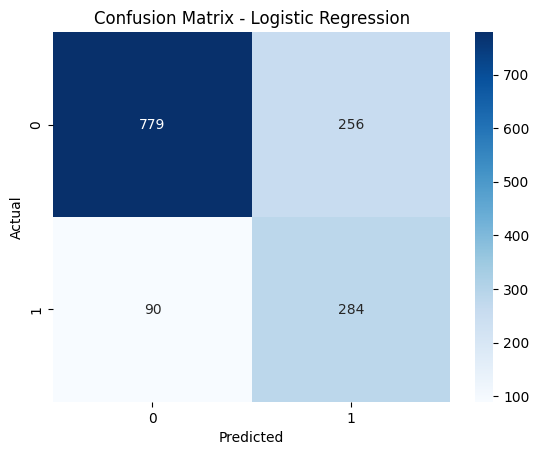

In [9]:
log_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(max_iter=2000, class_weight='balanced', solver='liblinear'))
])

log_pipe.fit(X_train, y_train)
y_pred_log = log_pipe.predict(X_test)
y_proba_log = log_pipe.predict_proba(X_test)[:, 1]

print("\nLogistic Regression performance:")
print_metrics(y_test, y_pred_log, y_proba_log)

cm = confusion_matrix(y_test, y_pred_log)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

# Random Forest Advanced Model 

Fitting 3 folds for each of 12 candidates, totalling 36 fits

Best RF params: {'clf__max_depth': 20, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
Random Forest performance:
Accuracy: 0.7289
Precision: 0.4933
Recall: 0.7914
F1-score: 0.6078
AUC: 0.8219


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [15] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [15] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


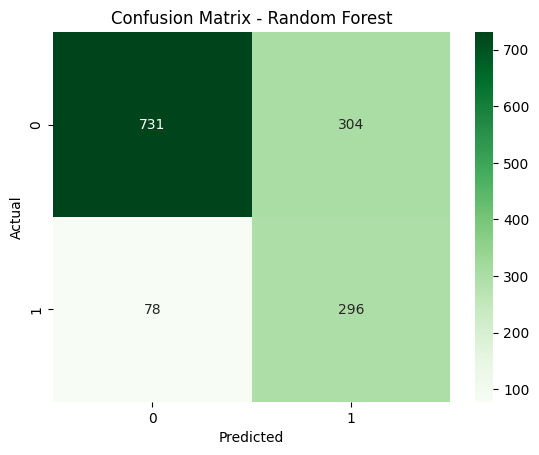

In [10]:
rf_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1))
])

param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 8, 20],
    'clf__min_samples_split': [2, 5]
}

gs_rf = GridSearchCV(rf_pipe, param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=1)
gs_rf.fit(X_train, y_train)

print("\nBest RF params:", gs_rf.best_params_)
y_pred_rf = gs_rf.predict(X_test)
y_proba_rf = gs_rf.predict_proba(X_test)[:, 1]

print("Random Forest performance:")
print_metrics(y_test, y_pred_rf, y_proba_rf)

cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()

# XGBOOST 

In [11]:
if xgboost_available:
    xgb_pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
    ])
    xgb_params = {'clf__n_estimators': [100, 200],
                  'clf__max_depth': [3, 6],
                  'clf__learning_rate': [0.1, 0.01]}
    gs_xgb = GridSearchCV(xgb_pipe, xgb_params, cv=3, scoring='f1', n_jobs=-1, verbose=1)
    gs_xgb.fit(X_train, y_train)
    print("\nBest XGB params:", gs_xgb.best_params_)
    y_pred_xgb = gs_xgb.predict(X_test)
    y_proba_xgb = gs_xgb.predict_proba(X_test)[:, 1]
    print("XGBoost performance:")
    print_metrics(y_test, y_pred_xgb, y_proba_xgb)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:51:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Best XGB params: {'clf__learning_rate': 0.1, 'clf__max_depth': 6, 'clf__n_estimators': 100}
XGBoost performance:
Accuracy: 0.7906
Precision: 0.6262
Recall: 0.5241
F1-score: 0.5706
AUC: 0.8373


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [15] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [15] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


# ROC Curves 

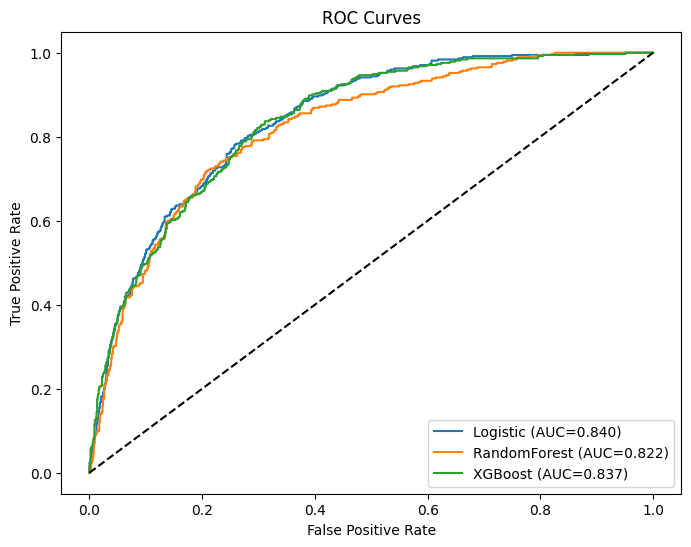

In [12]:
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, y_proba_log)
plt.plot(fpr, tpr, label=f'Logistic (AUC={roc_auc_score(y_test, y_proba_log):.3f})')
fpr, tpr, _ = roc_curve(y_test, y_proba_rf)
plt.plot(fpr, tpr, label=f'RandomForest (AUC={roc_auc_score(y_test, y_proba_rf):.3f})')
if xgboost_available:
    fpr, tpr, _ = roc_curve(y_test, y_proba_xgb)
    plt.plot(fpr, tpr, label=f'XGBoost (AUC={roc_auc_score(y_test, y_proba_xgb):.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

# Model Comparison Table 

In [13]:
rows = []

rows.append({
    'Model': 'LogisticRegression',
    'Accuracy': accuracy_score(y_test, y_pred_log),
    'Precision': precision_score(y_test, y_pred_log),
    'Recall': recall_score(y_test, y_pred_log),
    'F1': f1_score(y_test, y_pred_log),
    'AUC': roc_auc_score(y_test, y_proba_log)
})

rows.append({
    'Model': 'RandomForest',
    'Accuracy': accuracy_score(y_test, y_pred_rf),
    'Precision': precision_score(y_test, y_pred_rf),
    'Recall': recall_score(y_test, y_pred_rf),
    'F1': f1_score(y_test, y_pred_rf),
    'AUC': roc_auc_score(y_test, y_proba_rf)
})

if xgboost_available:
    rows.append({
        'Model': 'XGBoost',
        'Accuracy': accuracy_score(y_test, y_pred_xgb),
        'Precision': precision_score(y_test, y_pred_xgb),
        'Recall': recall_score(y_test, y_pred_xgb),
        'F1': f1_score(y_test, y_pred_xgb),
        'AUC': roc_auc_score(y_test, y_proba_xgb)
    })

In [14]:
comparison_df = pd.DataFrame(rows).set_index('Model').round(4)
print("\nModel Comparison:\n")
print(comparison_df)


Model Comparison:

                    Accuracy  Precision  Recall      F1     AUC
Model                                                          
LogisticRegression    0.7544     0.5259  0.7594  0.6214  0.8402
RandomForest          0.7289     0.4933  0.7914  0.6078  0.8219
XGBoost               0.7906     0.6262  0.5241  0.5706  0.8373


In [15]:
best_model = gs_rf.best_estimator_  # Example: Random Forest
joblib.dump(best_model, "best_churn_model.pkl")
print("\nSaved best model to best_churn_model.pkl")


Saved best model to best_churn_model.pkl
